# Hotel Review Rating

- Source Kaggle (https://www.kaggle.com/andrewmvd/trip-advisor-hotel-reviews) 
- Dataset file .csv. 
- Goal: given a set of reviews, we want to predict the rating value for each of them.

In [12]:
import pandas as pd
import re
import warnings
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve

## Data Exploration

In [2]:
# Loading Dataset
f = open('../HotelReview/tripadvisor_hotel_reviews.csv', encoding='utf8')
data = pd.read_csv(f)
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [3]:
data.shape

(20491, 2)

In [4]:
data.isnull().sum()

Review    0
Rating    0
dtype: int64

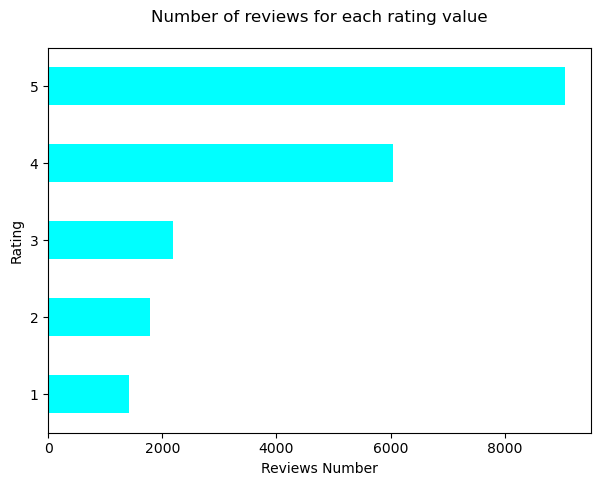

In [5]:
#Number of reviews for each rating value - Chart
fig = plt.figure(figsize=(7,5))
data.groupby('Rating').Review.count().sort_values().plot.barh(color='aqua', title='Number of reviews for each rating value\n')
plt.xlabel('Reviews Number', fontsize = 10);

## Data Cleaning

    Reviews belong to the category of unstructured data, so we need to convert them to structured type data using a 
    text-to-vector conversion.
    
    Before doing so, however, we need to work on the texts by removing anything unnecessary, such as special 
    characters, punctuation, and numbers.

In [6]:
# Reviews text cleaning
ps = PorterStemmer()
cleanedData = []
for i in range(0, len(data)):
    text = re.sub('[^a-zA-Z]', ' ', data['Review'][i])
    text = text.lower()
    text = text.split()
    text = [ps.stem(word) for word in text if not word in stopwords.words('english')]
    text = ' '.join(text)
    cleanedData.append(text)
#cleanedData[2]

In [7]:
# Converting text to vectors using TfidfVectorizer
# ngrams = (1,3) --> 1- to 3-word combinations
tfidf = TfidfVectorizer(max_features = 10000, ngram_range = (1,3))
reviews = tfidf.fit_transform(cleanedData).toarray()

In [8]:
# Training set, validation set and test set
x_train, x_test, y_train, y_test = train_test_split(reviews, data['Rating'], test_size = 0.25, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=1)
print('Training set -->', 'X:' ,x_train.shape, 'Y:',y_train.shape)
print('Test set -->', 'X:', x_test.shape, 'Y:', y_test.shape)
print('Validation set -->', 'X:', x_val.shape, 'Y:', y_val.shape)

Training set --> X: (12294, 10000) Y: (12294,)
Test set --> X: (5123, 10000) Y: (5123,)
Validation set --> X: (3074, 10000) Y: (3074,)


## Function Definition
  

In [9]:
def plot_learning_curves(model, x, y):
    warnings.filterwarnings("ignore")
    
    train_size, train_error, cv_error = learning_curve(model, x, y, scoring='neg_log_loss', cv=5, 
                                                        train_sizes=[10, 50, 100, 500, 100],
                                                        shuffle=True, random_state=90)

    train_error_mean = -train_error.mean(axis = 1) #- per invertire i valori negativi della funzione di costo
    cv_error_mean = -cv_error.mean(axis = 1)

   
    print()
    plt.title('LEARNING CURVES')
    plt.plot(train_size, train_error_mean, label = 'Training error', color='green')
    plt.plot(train_size, cv_error_mean, label = 'Validation error', color='blue')
    plt.ylabel('Error', fontsize = 15)
    plt.xlabel('Training set size', fontsize = 15)
    plt.legend() 

In [10]:
def model_evaluation (model, predictions, x_train, y_train, x_test, y_test, x_val, y_val):
    #Accuracy per training set, test set e validation set
    print()
    print("Training set accuracy: ", model.score(x_train, y_train) )
    print("Test set accuracy: ", model.score(x_test, y_test) )
    print("Validation set accuracy: ", model.score(x_val, y_val) )

    #Confusion Matrix
    disp = metrics.plot_confusion_matrix(model, x_val, y_val)
    disp.confusion_matrix
    print(metrics.classification_report(y_val, predictions))

## Testing of different classification algorithms:

  - Logistic Regression
  - SVM
  - Decision Tree
  - Multinomial Naive Bayes
  - Neural Networks



Training set accuracy:  0.7644379372051407
Test set accuracy:  0.6092133515518251
Validation set accuracy:  0.6119063109954457
              precision    recall  f1-score   support

           1       0.72      0.58      0.64       190
           2       0.48      0.31      0.38       268
           3       0.51      0.18      0.27       344
           4       0.50      0.47      0.49       895
           5       0.68      0.87      0.76      1377

    accuracy                           0.61      3074
   macro avg       0.58      0.48      0.51      3074
weighted avg       0.59      0.61      0.59      3074



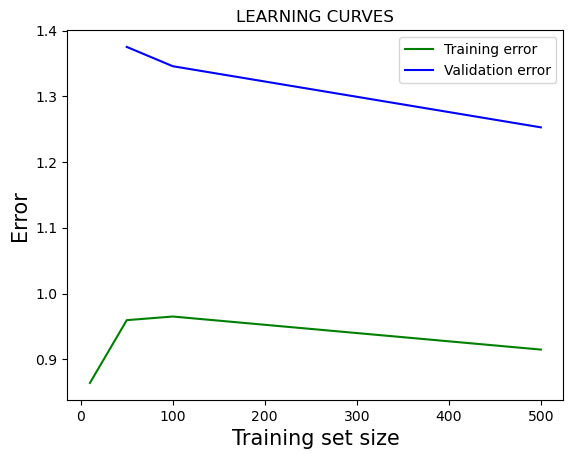

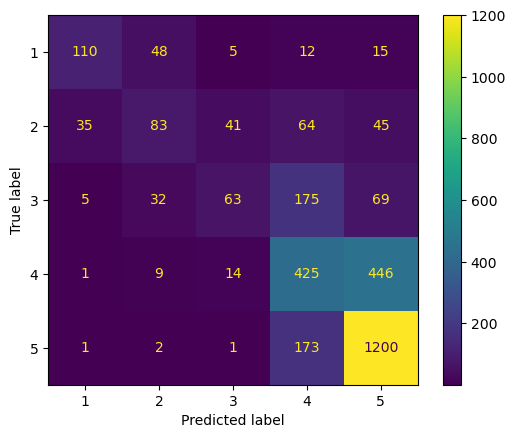

In [13]:
#Logistic Regression
from sklearn import linear_model
lg_model = linear_model.LogisticRegression(C=1,multi_class='ovr', solver='liblinear').fit(x_train, y_train)
lg_predictions = lg_model.predict(x_val)

plot_learning_curves(lg_model, x_train, y_train)
model_evaluation (lg_model, lg_predictions, x_train, y_train, x_test, y_test, x_val, y_val)



Training set accuracy:  0.6964372864812104
Test set accuracy:  0.4928752683974234
Validation set accuracy:  0.47722836694860116
              precision    recall  f1-score   support

           1       0.38      0.47      0.42       190
           2       0.31      0.19      0.24       268
           3       0.27      0.10      0.15       344
           4       0.36      0.40      0.38       895
           5       0.60      0.68      0.64      1377

    accuracy                           0.48      3074
   macro avg       0.39      0.37      0.36      3074
weighted avg       0.46      0.48      0.46      3074



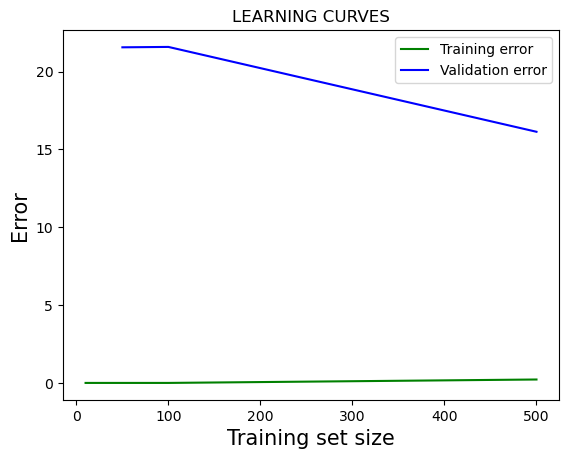

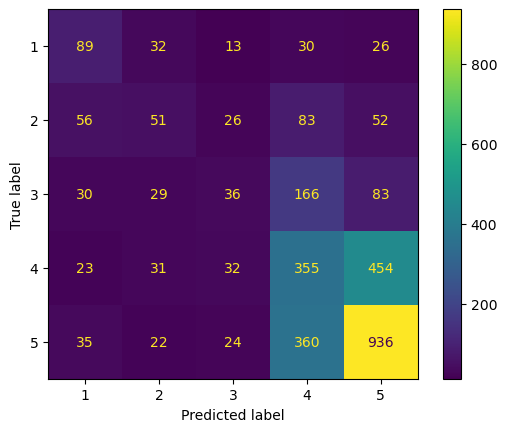

In [14]:
#Decision Tree
dt_model = DecisionTreeClassifier(max_depth = 15).fit(x_train, y_train) 
dt_predictions = dt_model.predict(x_val) 

plot_learning_curves(dt_model, x_train, y_train)
model_evaluation (dt_model, dt_predictions, x_train, y_train, x_test, y_test, x_val, y_val)



Training set accuracy:  0.7919310232633805
Test set accuracy:  0.5836423970329885
Validation set accuracy:  0.5767729342875731
              precision    recall  f1-score   support

           1       0.68      0.34      0.45       190
           2       0.39      0.29      0.34       268
           3       0.35      0.12      0.18       344
           4       0.46      0.50      0.48       895
           5       0.68      0.83      0.75      1377

    accuracy                           0.58      3074
   macro avg       0.51      0.42      0.44      3074
weighted avg       0.55      0.58      0.55      3074



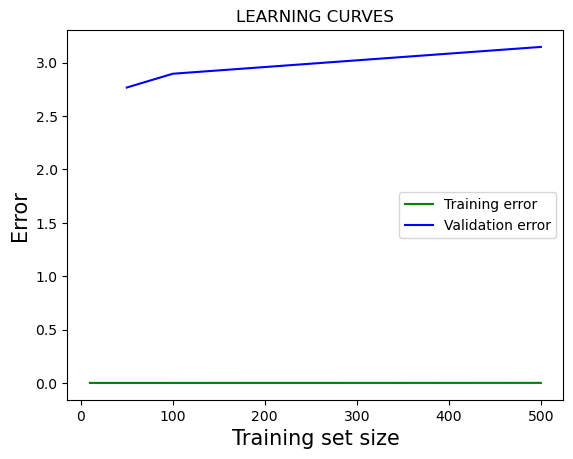

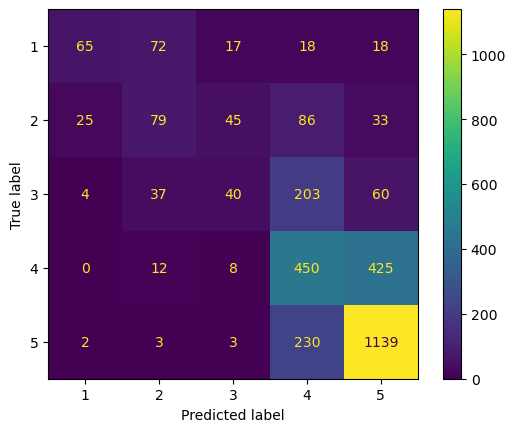

In [15]:
#Multinomial Naive Bayes
mb_model = MultinomialNB(alpha= 0.0001).fit(x_train, y_train) 
mb_predictions = mb_model.predict(x_val) 

plot_learning_curves(mb_model, x_train, y_train)
model_evaluation (mb_model, mb_predictions, x_train, y_train, x_test, y_test, x_val, y_val)


Training set accuracy:  0.854644542053034
Test set accuracy:  0.6129221159476869
Validation set accuracy:  0.6119063109954457
              precision    recall  f1-score   support

           1       0.64      0.64      0.64       190
           2       0.48      0.35      0.40       268
           3       0.46      0.23      0.30       344
           4       0.51      0.48      0.49       895
           5       0.69      0.84      0.76      1377

    accuracy                           0.61      3074
   macro avg       0.56      0.51      0.52      3074
weighted avg       0.59      0.61      0.59      3074



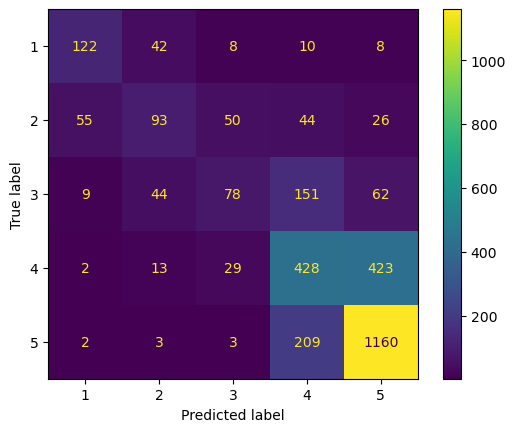

In [16]:
#SVM
svm_model = svm.LinearSVC(C=0.25).fit(x_train, y_train)
svm_predictions = svm_model.predict(x_val) 

model_evaluation (svm_model, svm_predictions, x_train, y_train, x_test, y_test, x_val, y_val)



Training set accuracy:  0.9976411257523995
Test set accuracy:  0.5213741948077298
Validation set accuracy:  0.522121014964216
              precision    recall  f1-score   support

           1       0.67      0.52      0.58       190
           2       0.40      0.25      0.30       268
           3       0.37      0.21      0.27       344
           4       0.42      0.42      0.42       895
           5       0.59      0.72      0.65      1377

    accuracy                           0.52      3074
   macro avg       0.49      0.42      0.44      3074
weighted avg       0.51      0.52      0.51      3074



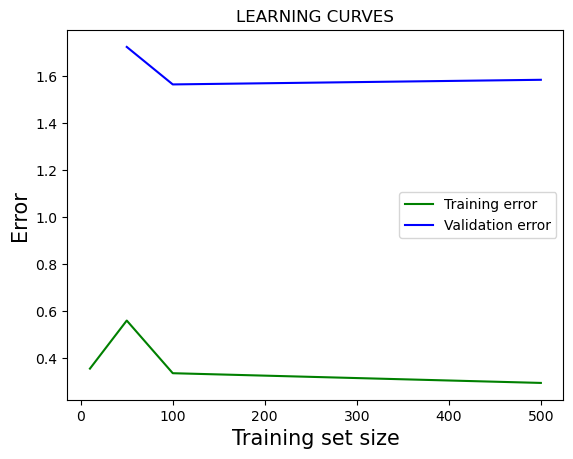

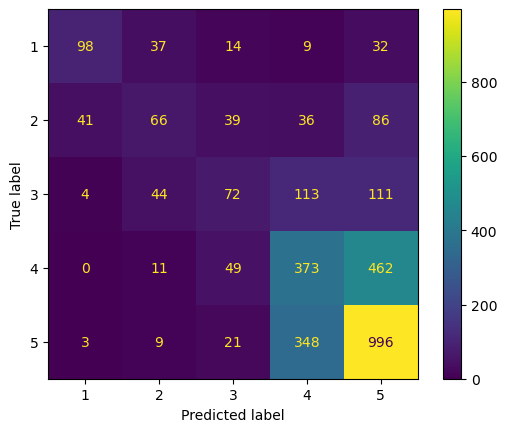

In [17]:
#Neural Networks with OneVsAll
nn_model = OneVsRestClassifier(MLPClassifier(solver = 'lbfgs', hidden_layer_sizes = (5,2), alpha = 0.2))
nn_model.fit(np.array(x_train), y_train)
nn_predictions = nn_model.predict(x_val)

plot_learning_curves(nn_model, x_train, y_train)
model_evaluation (nn_model, nn_predictions, x_train, y_train, x_test, y_test, x_val, y_val)

In [18]:
#Comparison of different models tested
from tabulate import tabulate
models = [lg_model, svm_model, dt_model, mb_model, nn_model]
results = []
for model in models:
    model_name = model.__class__.__name__
    training_score = model.score(x_train, y_train)
    test_score = model.score(x_test, y_test)
    validation_score = model.score(x_val, y_val)
    results.append((model_name, training_score, test_score, validation_score))

print()
print(tabulate(results, headers= ['Model', 'Training score', 'Test Score', 'Validation Score']))


Model                     Training score    Test Score    Validation Score
----------------------  ----------------  ------------  ------------------
LogisticRegression              0.764438      0.609213            0.611906
LinearSVC                       0.854645      0.612922            0.611906
DecisionTreeClassifier          0.696437      0.492875            0.477228
MultinomialNB                   0.791931      0.583642            0.576773
OneVsRestClassifier             0.997641      0.521374            0.522121


# Conclusions

Logistic regression and SVM with linear kernel were the first choices because they are simple and work similarly for problems with a similar number of features and training data.
Given the overfitting problem, after using various techniques, we proceeded to test other models such as decision trees and Nayve Bayes, but without getting better results.
Because the size of the dataset is very small, neural networks had not been considered previously, but as a last attempt we tried using them and working on the number of hidden layers. The results worsen significantly by increasing even slightly the number of hidden layers or trying to work on the regularization parameter.
In general, the various models used fail to make satisfactory predictions, all suffering from overfitting. The decidedly large gap present in the learning curves is further confirmation of this.
Several techniques have been applied to improve the models: the use of training set division, validation set, test set, increasing the regularization parameter or decreasing the C parameter, and using fewer features.
All of the solutions adopted in many cases proved ineffective, at best very good accuracy was obtained on the training set, but very bad for the validation and test sets, an indication that the model has strong generalization difficulties when it comes to making predictions on new data. Some improvement was found only with SVM, with slightly better accuracy on all three sets.